In [1]:
import cv2
import numpy as np
import os
import tarfile
import urllib

from matplotlib import pyplot as plt
import tensorflow as tf

### 이미지 불러오기

In [3]:
import os
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/hansohi.jpg'  # 본인이 선택한 이미지의 경로에 맞게 바꿔주기 
img_orig = cv2.imread(img_path) 
print (img_orig.shape)

(538, 480, 3)


시맨틱 세그멘테이션으로 사람 분리하기

구글에서 제공하는 `DeepLab` 모델 구조를 그대로 가지고 와 `DeepLabModel` 클래스를 만든다.

- `preprocess()`는 전처리
- `run()`은 실제로 세그멘테이션을 하는 함수

먼저 input tensor를 만들기 위해 `preprocess()` 함수에서 이미지를 전처리 한다.

모델이 받는 입력 크기가 정해져 있으므로 이에 따라 적절한 크기로 resize 하고, OpenCV의 디폴트 BGR 채널 순서를 텐서플로우에 맞는 RGB로 수정한다.
전처리된 이미지는 `run()` 함수에서 입력값으로 사용된다.

In [4]:
class DeepLabModel(object):
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513
    FROZEN_GRAPH_NAME = 'frozen_inference_graph'

    # __init__()에서 모델 구조를 직접 구현하는 대신, tar file에서 읽어들인 그래프구조 graph_def를 
    # tf.compat.v1.import_graph_def를 통해 불러들여 활용하게 됩니다. 
    def __init__(self, tarball_path):
        self.graph = tf.Graph()
        graph_def = None
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
                break
        tar_file.close()

        with self.graph.as_default():
    	    tf.compat.v1.import_graph_def(graph_def, name='')

        self.sess = tf.compat.v1.Session(graph=self.graph)

    # 이미지를 전처리하여 Tensorflow 입력으로 사용 가능한 shape의 Numpy Array로 변환합니다.
    def preprocess(self, img_orig):
        height, width = img_orig.shape[:2]
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = cv2.resize(img_orig, target_size)
        resized_rgb = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)
        img_input = resized_rgb
        return img_input
        
    def run(self, image):
        img_input = self.preprocess(image)

        # Tensorflow V1에서는 model(input) 방식이 아니라 sess.run(feed_dict={input...}) 방식을 활용합니다.
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [img_input]})

        seg_map = batch_seg_map[0]
        return cv2.cvtColor(img_input, cv2.COLOR_RGB2BGR), seg_map

구글에서 제공하는 사전에 학습된 가중치(pretrained weight)를 불러온다.

In [5]:
# define model and download & load pretrained weight
_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'

model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
tf.io.gfile.makedirs(model_dir)

print ('temp directory:', model_dir)

download_path = os.path.join(model_dir, 'deeplab_model.tar.gz')
if not os.path.exists(download_path):
    urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + 'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
                   download_path)

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

temp directory: /aiffel/aiffel/human_segmentation/models
model loaded successfully!


구글이 제공하는  `deeplabv3_mnv2_pascal_train_aug_2018_01_29` weight을 다운로드하고 DeepLabModel 을 초기화한다.    
이 모델은 PASCAL VOC 2012라는 대형 데이터셋으로 학습된 v3 버전이며,   
다양한 데이터셋과 백본(backbone) 모델에 대한 `pretrained weight`은 [링크](https://github.com/tensorflow/models/blob/master/research/deeplab/g3doc/model_zoo.md)에서 확인할 수 있다.

In [6]:
img_resized, seg_map = MODEL.run(img_orig)
print (img_orig.shape, img_resized.shape, seg_map.max())

(538, 480, 3) (513, 457, 3) 15


위의 `DeepLab`은 `PASCAL VOC`의 라벨로 학습되었으며, 제공하는 라벨 종류는 아래와 같다.

In [7]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

background를 제외하면 20개의 클래스가 있으며, 따라서 20 의 의미는 tv 이다. (인덱스는 0부터 시작)   
사람(person) 라벨를 검출하려면 15를 쓰면된다.

사람을 뜻하는 15 외 예측은 0으로 만들고, 예측된 세그멘테이션 이미지(map)는 최댓값이 15가 된다.    
일반 이미지는 0부터 255 까지의 값을 사용해 픽셀을 표현하므로, 세그멘테이션 맵에 표현된 값을 원본 이미지에 그림 형태로 출력하기 위해 255로 정규화 한다. 
`applyColorMap()` 함수로 색을 적용하고 이미지를 화면에 출력해보자

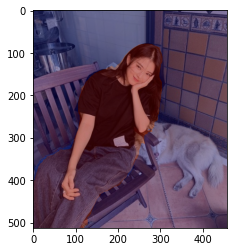

In [8]:
img_show = img_resized.copy()
seg_map = np.where(seg_map == 15, 15, 0) # 예측 중 사람만 추출
img_mask = seg_map * (255/seg_map.max()) # 255 normalization
img_mask = img_mask.astype(np.uint8)
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.35, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

DeepLab 모델을 사용하기 위해 이미지 크기를 작게 resize 해서 입력했으며, 그에 따라서 출력도 resize 된 입력 크기와 같게 나온다.   
세그멘테이션 결과(mask)를 원래 크기로 복원해보자.

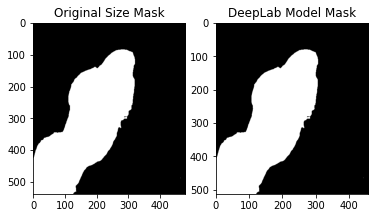

In [9]:
### 세그멘테이션 결과를 원래 크기로 복원하기
img_mask_up = cv2.resize(img_mask, img_orig.shape[:2][::-1], interpolation=cv2.INTER_LINEAR)
_, img_mask_up = cv2.threshold(img_mask_up, 128, 255, cv2.THRESH_BINARY)

ax = plt.subplot(1,2,1)
plt.imshow(img_mask_up, cmap=plt.cm.binary_r)
ax.set_title('Original Size Mask')

ax = plt.subplot(1,2,2)
plt.imshow(img_mask, cmap=plt.cm.binary_r)
ax.set_title('DeepLab Model Mask')

plt.show()

`cv2.resize()` 함수를 이용한다.    
크기를 키울 때 `보간(interpolation)` 을 고려해야 하는데,    
`cv2.INTER_NEAREST`를 이용해서 깔끔하게 처리할 수 있지만 더 정확히 확대하기 위해 `cv2.INTER_LINEAR` 를 사용해보자.    
여기서 `보간법(interpolation)`은 이미지의 크기를 변경(scaling)하는 과정에서 컴퓨터가 사이사이 픽셀값을 채우는 방법이며,    
자세한 설명은 [opencv-python](https://opencv-python.readthedocs.io/en/latest/doc/10.imageTransformation/imageTransformation.html) 문서를 참고하자.

`img_mask_up`은 경계가 블러된 픽셀값 0~255의 이미지를 얻는다.    
확실한 경계를 다시 정하기 위해 중간값인 128을 기준으로 `임계값(threshold)`을 설정하며,   
128 이하의 값은 0으로 128 이상의 값은 255로 만드는 방법이다.

`blur()`함수를 이용하여 배경을 흐리게 만든다.    

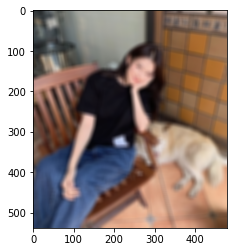

In [10]:
### 배경흐리게 하기
img_orig_blur = cv2.blur(img_orig, (13,13)) #(13,13)은 blurring  kernel size를 뜻합니다. 
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

`bitwise_not`함수를 이용하면 이미지가 반전되며, 배경은 `255` 사람은 `0`이 된다.    
반전된 세그멘테이션 결과를 이용해서 이미지와 `bitwise_and` 연산을 수행하면 배경만 있는 영상을 얻을 수 있다.   
[stack overflow bitwise not과 and를 사용하여 이미지 바꾸기](https://stackoverflow.com/questions/32774956/explain-arguments-meaning-in-res-cv2-bitwise-andimg-img-mask-mask)

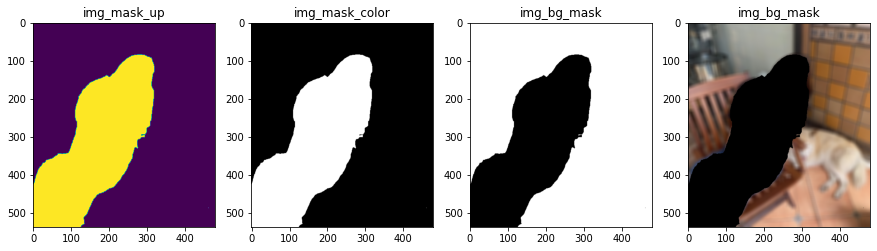

In [11]:
### 마스크 과정 살펴보기
fig = plt.figure(figsize=(15,18))
ax1 = fig.add_subplot(1, 4, 1)
ax1.imshow(img_mask_up)
ax1.set_title("img_mask_up")

img_mask_color = cv2.cvtColor(img_mask_up, cv2.COLOR_GRAY2BGR)
ax2 = fig.add_subplot(1, 4, 2)
ax2.imshow(img_mask_color)
ax2.set_title("img_mask_color")


img_bg_mask = cv2.bitwise_not(img_mask_color)
ax3 = fig.add_subplot(1, 4, 3)
ax3.imshow(img_bg_mask)
ax3.set_title("img_bg_mask")


img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
ax4 = fig.add_subplot(1, 4, 4)
ax4.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
ax4.set_title("img_bg_mask")

plt.show()

이제 blur처리한 배경과 사람들 추출한 이미지를 합성시켜보자.   
[numpy.where() 사용법](https://numpy.org/doc/stable/reference/generated/numpy.where.html)

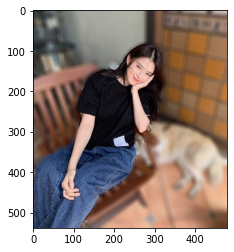

In [12]:
### 흐린 배경과 원본 영상 합성
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()